![framwork](./framework.png)

## ARIMA, ARIMAX & SARMAX | BTC - EUR

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import pmdarima as pm
import warnings

from cycler import cycler
from eda import *
from math import sqrt
from matplotlib import pyplot as plt
from gradientBoosting import *
from mertonJumpDiffusion import *
from models_utils import *
from scipy import stats
from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf_ols
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings('ignore')
alt.data_transformers.disable_max_rows()
plt.rcParams['axes.prop_cycle'] = cycler(color=plt.cm.tab20.colors)

custom_colors = ["#948B80", "#625D56", "#312E2B", "#875C62", "#5F4045", "#B79DA1",
                "#417156", "#2E4F3C", "#6D7C73"]  # Replace with your colors

In [111]:
exchange = pd.read_csv("exchange_v2.csv")
exchange.head()

date      Open      High       Low     Close  Adj Close  Volume  \
0  2014-09-17  1.295908  1.298000  1.294090  1.295908   1.295908       0   
1  2014-09-18  1.285017  1.292689  1.285017  1.285000   1.285000       0   
2  2014-09-19  1.292140  1.292959  1.283203  1.292006   1.292006       0   
3  2014-09-22  1.284076  1.286900  1.281953  1.284142   1.284142       0   
4  2014-09-23  1.285298  1.289930  1.284589  1.285149   1.285149       0   

   currency  
0  EURUSD=X  
1  EURUSD=X  
2  EURUSD=X  
3  EURUSD=X  
4  EURUSD=X

###  Plotting the data

alt.Chart(...)

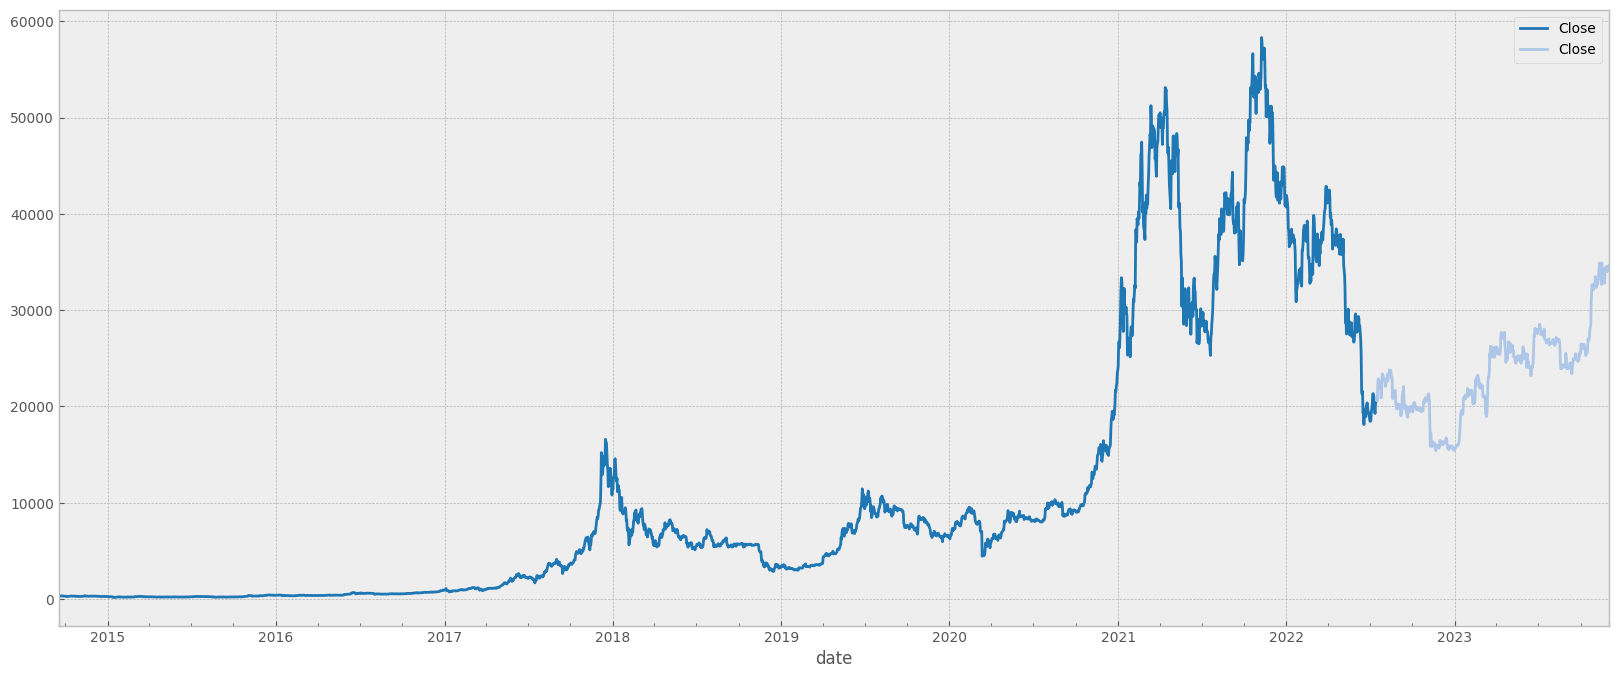

In [112]:
currency = "BTC-EUR"
train_df, test_df = load_train_test_data(
    file_name='exchange_v2.csv', 
    currency=currency,
    train_size=0.85
)

# Add a new column to each dataframe to indicate the dataset type
train_df['Dataset'] = 'Train'
test_df['Dataset'] = 'Test'

# Concatenate the dataframes
combined_df = pd.concat([train_df, test_df])

# Create a single chart with a color encoding based on the dataset type
chart = alt.Chart(combined_df).mark_line(strokeWidth=0.8).encode(
    x=alt.X('date:T', axis=alt.Axis(format='%Y-%m')),
    y=alt.Y('Close:Q', scale=alt.Scale(domain=[combined_df['Close'].min() - 0.05, combined_df['Close'].max() + 0.05])),
    color=alt.Color('Dataset:N', scale=alt.Scale(range=["#625D56", "#2E4F3C"]))
).properties(
    width=800,
    height=300,
    title=f"{currency} Exchange Rate: Train/Test Split"
)

chart.save('graphs/btceur/a_train_validation_test_split.json')
chart

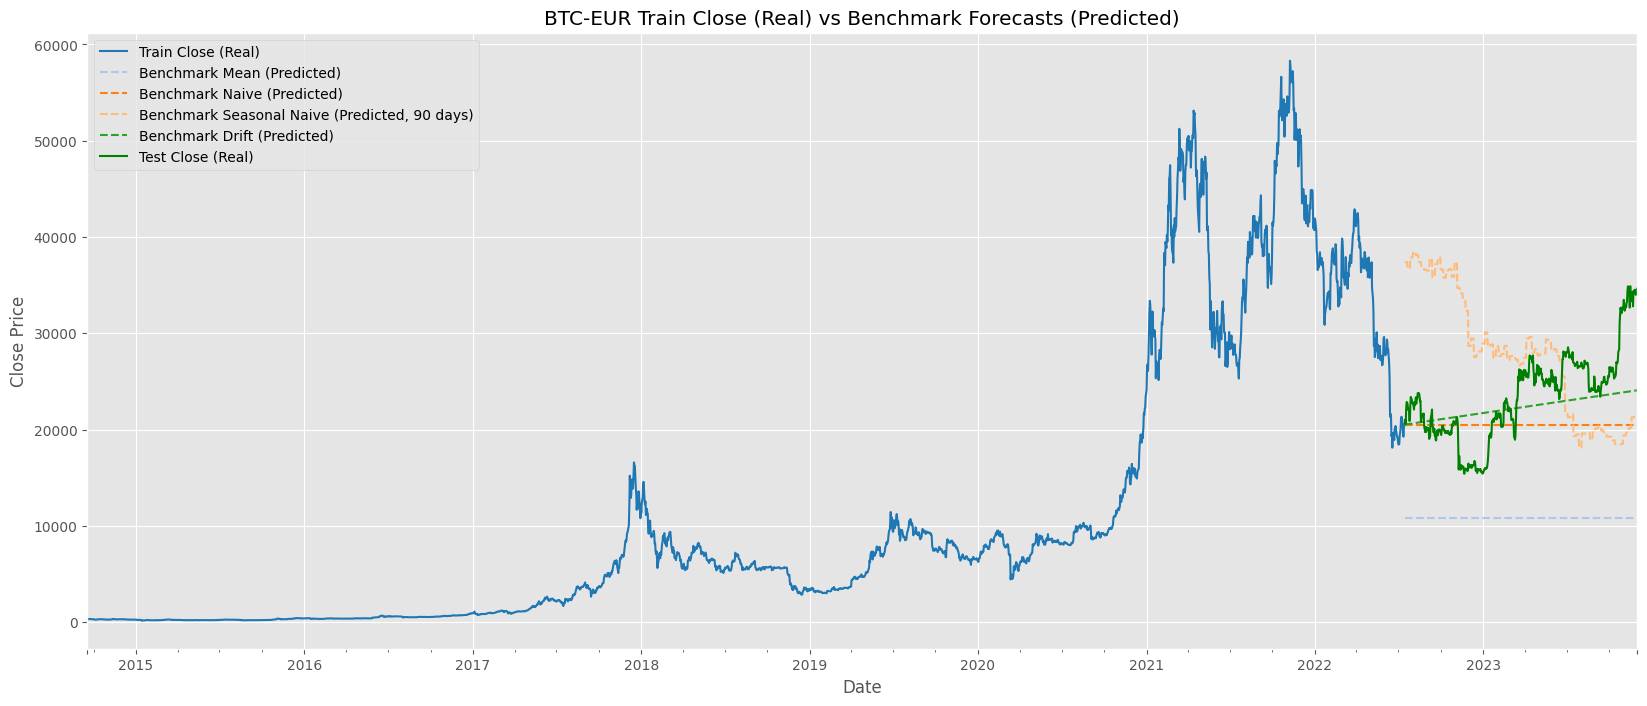

In [4]:
train_df, charts = preprocess(train_df, windows=(1, 3, 7, 30, 90, 365))
train_df, test_df = calc_benchmarks(train_df, test_df, seasonality=90)

In [5]:
benchmark_cols = [col for col in test_df.columns if "bench" in col]
benchmark_cols.append('Close')

# Reshape the DataFrame
long_df = test_df.melt(id_vars=['date'], value_vars=benchmark_cols, var_name='Benchmark', value_name='Value')

# Create the Altair Chart
chart = alt.Chart(long_df).mark_line(strokeWidth=0.6, point=False).encode(
    x=alt.X('date:T', axis=alt.Axis(format='%Y-%m')),
    y=alt.Y('Value:Q', scale=alt.Scale(domain=[10000, 50000])),
    color=alt.Color('Benchmark:N', scale=alt.Scale(range=custom_colors))
).properties(
    width=800,
    height=300,
    title=f"{currency} Benchmark models against Test Dataset."
).configure_point(
    size=10
)

# Line chart for actual data
actual_line = alt.Chart(long_df).mark_area(
    line={"color": "#F6E8D6", "strokeWidth":0.3},
    color=alt.Gradient(
        gradient="linear",
        stops=[
            alt.GradientStop(color="white", offset=0),
            alt.GradientStop(color="#F6E8D6", offset=1),
        ],
        x1=1,
        x2=1,
        y1=1,
        y2=0,
    ),
    strokeDash=[1,1]
).encode(
    y=alt.Y('Close:Q', scale=alt.Scale(domain=[10000, 50000]))
)

# Save the chart
chart.save('graphs/btceur/b_benchmarks.json')

chart

alt.Chart(...)

In [6]:
# List of benchmark columns
benchmark_cols = ['bench_mean_Close', 'bench_naive_Close', 
                  'bench_drift_Close', 'bench_seasonal_naive_Close']

# Calculate residuals and store in a new DataFrame
residuals_df = pd.DataFrame()

for col in benchmark_cols:
    residuals_df[f'residual_{col}'] = test_df['Close'] - test_df[col]

# Melt the DataFrame into long format for Altair
residuals_long_df = residuals_df.reset_index().melt('date', var_name='method', value_name='residual')

# Define the color scheme
# Use as many colors as you have lines
color_scheme = alt.Scale(domain=['residual_bench_mean_Close', 'residual_bench_naive_Close', 
                                 'residual_bench_drift_Close', 'residual_bench_seasonal_naive_Close'],
                         range=["#948B80", "#625D56", "#312E2B", "#875C62"])

# Create the Altair chart
chart = alt.Chart(residuals_long_df).mark_line().encode(
    x=alt.X('date:T', axis=alt.Axis(format='%Y-%m')),  # Assuming the index of residuals_df is a timestamp
    y='residual:Q',
    color=alt.Color('method:N', scale=color_scheme),
    tooltip=['date', 'residual', 'method']
).properties(
    width=800,
    height=400,
    title="Benchmark Residuals Plot"
)

chart

alt.Chart(...)

In [7]:
#calculate metrics for the benchmarking models
benchmark_metrics = calculate_forecast_metrics(test_df, actual_col='Close', benchmark_cols=benchmark_cols)
#benchmark_metrics.to_csv("graphs/btcusd/benchmark_metrics.csv")
benchmark_metrics.T

MAE           MSE          RMSE  \
bench_mean_Close            12620.294932  1.800650e+08  13418.830374   
bench_naive_Close            4293.383248  2.925020e+07   5408.345856   
bench_drift_Close            3114.566157  1.599796e+07   3999.745519   
bench_seasonal_naive_Close   9437.960630  1.183585e+08  10879.270756   

                                 MAPE        R2  
bench_mean_Close            52.049349 -7.659817  
bench_naive_Close           17.347756 -0.406722  
bench_drift_Close           13.430396  0.230614  
bench_seasonal_naive_Close  44.261298 -4.692185

### Autocorrelation of the data

In [8]:
# Function to calculate autocorrelation
def autocorr(series, lag):
    return series.autocorr(lag)

# Calculate ACF values
N = len(train_df['Close'].dropna())
lags = 120
acf_values = [autocorr(train_df['Close'].dropna(), lag) for lag in range(lags + 1)]


# Calculate confidence intervals
upper_bounds = [2 / np.sqrt(N/l) for l in range(1, lags+2)]
lower_bounds = [-2 / np.sqrt(N/l) for l in range(1, lags+2)]

# Create a DataFrame for plotting
acf_df = pd.DataFrame({
    'Lag': np.arange(lags + 1),
    'Autocorrelation': acf_values,
    'UpperBound': upper_bounds,
    'LowerBound': lower_bounds
})

base = alt.Chart(acf_df).encode(x='Lag:O')

# Line chart for ACF values (sticks of the lollipops)
acf_line = base.mark_bar(color='#417156', size=3, opacity=0.8).encode(
    y='Autocorrelation:Q'
)

# Point chart for ACF values (lollipops)
acf_points = base.mark_point(color='#417156', size=25, filled=True, opacity=1).encode(
    y='Autocorrelation:Q'
)

# Area chart for the confidence interval
confidence_interval = base.mark_area(color='#F6E8D6', opacity=0.6).encode(
    y='UpperBound:Q',
    y2='LowerBound:Q'
)

# Combine the charts
combined_chart = alt.layer(confidence_interval, acf_line, acf_points).properties(
    width=750,
    height=400,
    title="Autocorrelation Function (ACF) of Closing price for 120 Lags"
)

# Dummy data for the legend
legend_data = pd.DataFrame({
    'category': ['Autocorrelation', 'Confidence Interval'],
    'color': ['#417156', '#F6E8D6']
})

# Create a legend chart
legend = alt.Chart(legend_data).mark_point(size=100, filled=True).encode(
    y=alt.Y('category:N', axis=alt.Axis(orient='right'), title=None),
    color=alt.Color('color:N', scale=None)
)

# Combine the chart with the legend
final_chart = alt.hconcat(combined_chart, legend, spacing=5)

final_chart

alt.HConcatChart(...)

### Transform the Data

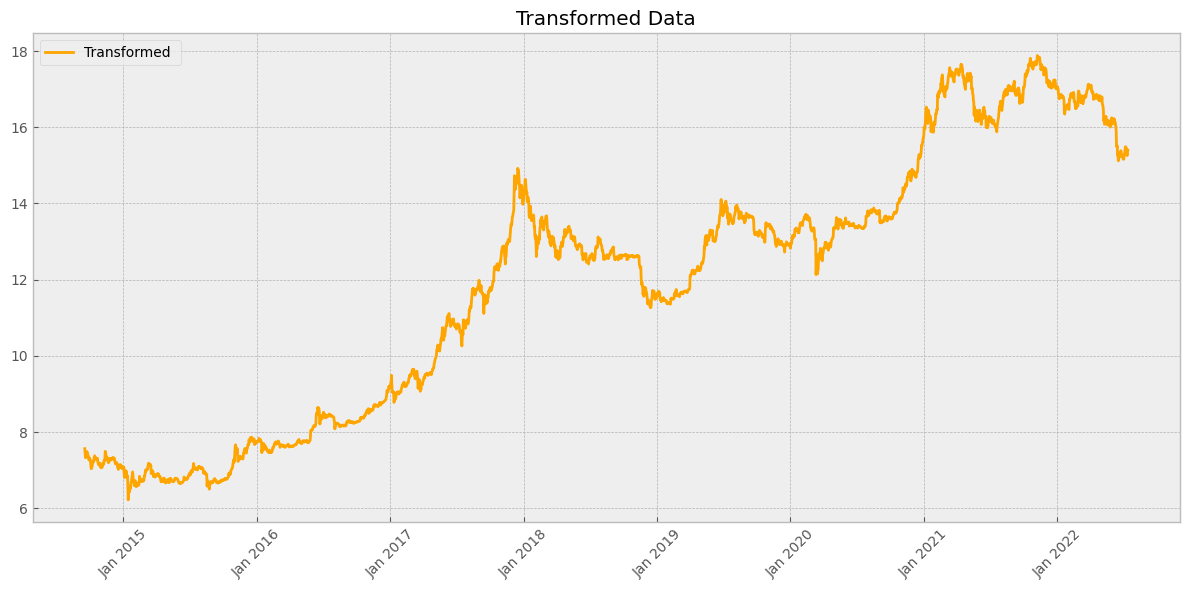

In [93]:
# # Apply box-cox transformation to the data
train_df['transf'], lambda_optimal = stats.boxcox(train_df['Close'])

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(train_df['date']), train_df['transf'], label='Transformed ', color='orange')
plt.title('Transformed Data')
plt.legend()
plt.grid(True)

# Set the date format for x-axis ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Specify the frequency of ticks for months
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
# Assuming train_df_btc and currency are already defined
chart = alt.Chart(train_df).mark_line(strokeWidth=0.8, color="#948B80").encode(  # Set custom color here
    x=alt.X('date:T', axis=alt.Axis(format='%Y-%m')),
    y=alt.Y('transf:Q', scale=alt.Scale(domain=[train_df['transf'].min() - 0.05, train_df['transf'].max() + 0.05]))
).properties(
    width=800,
    height=300,
    title=f"{currency} Exchange Rate: Transformed"
)

# Save 
chart.save('graphs/btceur/normalized.json')
chart

alt.Chart(...)

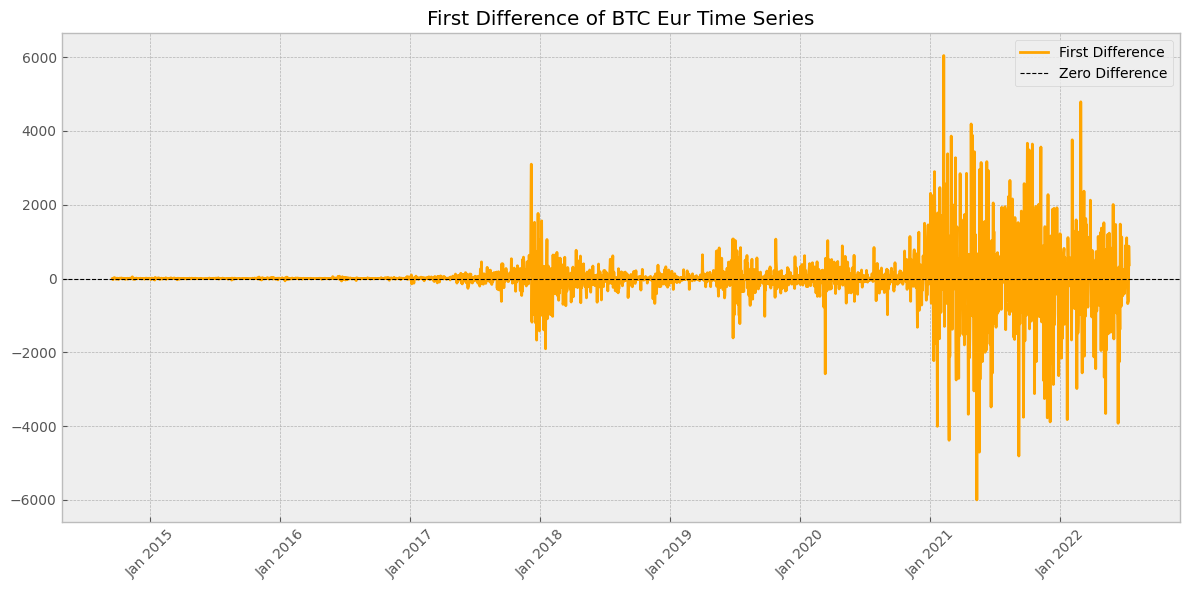

In [56]:
# Apply first differencing and check autocorrelation and plot

# Calculate the first difference
btceur_diff = train_df.copy()
btceur_diff['diff'] = pd.Series.diff(train_df['Close'])
btceur_diff.fillna(0, inplace=True)

# Plot only the first difference
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(btceur_diff['date']), btceur_diff['diff'], label='First Difference', color='orange')
plt.title('First Difference of BTC Eur Time Series')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8, label='Zero Difference')
plt.legend()
plt.grid(True)

# Set the date format for x-axis ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Specify the frequency of ticks for months
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [57]:
# Changing the color of the line chart
line_chart = alt.Chart(btceur_diff).mark_line(color="#948B80").encode(  # Custom color set here
    x=alt.X('date:T', title='Date', axis=alt.Axis(format='%b %Y')),  # Custom date formatting
    y=alt.Y('diff:Q', title='First Difference')
).properties(
    width=800,
    height=400,
    title='First Difference of BTC Eur Time Series'
)

# Create a horizontal line at y=0
hline = alt.Chart().mark_rule(color='black', strokeDash=[5, 5]).encode(
    y=alt.Y('a:Q', axis=alt.Axis(title='')),
    size=alt.SizeValue(0.8)
).transform_calculate(
    a="0"
)

# Combine the charts
final_chart = (line_chart + hline).configure_axis(
    grid=True
).configure_view(
    strokeWidth=0
)

final_chart

alt.LayerChart(...)

### Autocorrelation and Partial Autocorrelation

In [58]:
acorr = sm.tsa.acf(btceur_diff['diff'], nlags = 2857)

# Lags in terms of 1 day, 1 month, 1 quarter, 1 year, 2 years, 5 years, and last lag
lags_of_interest = [0, 1, 30, 90, 365, 730, 1825, 2857]

# Print autocorrelations for specified lags
for lag in lags_of_interest:
    print(f'Lag {lag} ({lag} days): {acorr[lag]}')

Lag 0 (0 days): 1.0
Lag 1 (1 days): -0.026677770979860335
Lag 30 (30 days): 0.016553908186526446
Lag 90 (90 days): -0.048216595368764735
Lag 365 (365 days): -0.04791744926862869
Lag 730 (730 days): -0.011982649734482846
Lag 1825 (1825 days): 0.0001585263715126406
Lag 2857 (2857 days): -1.932055380610893e-06


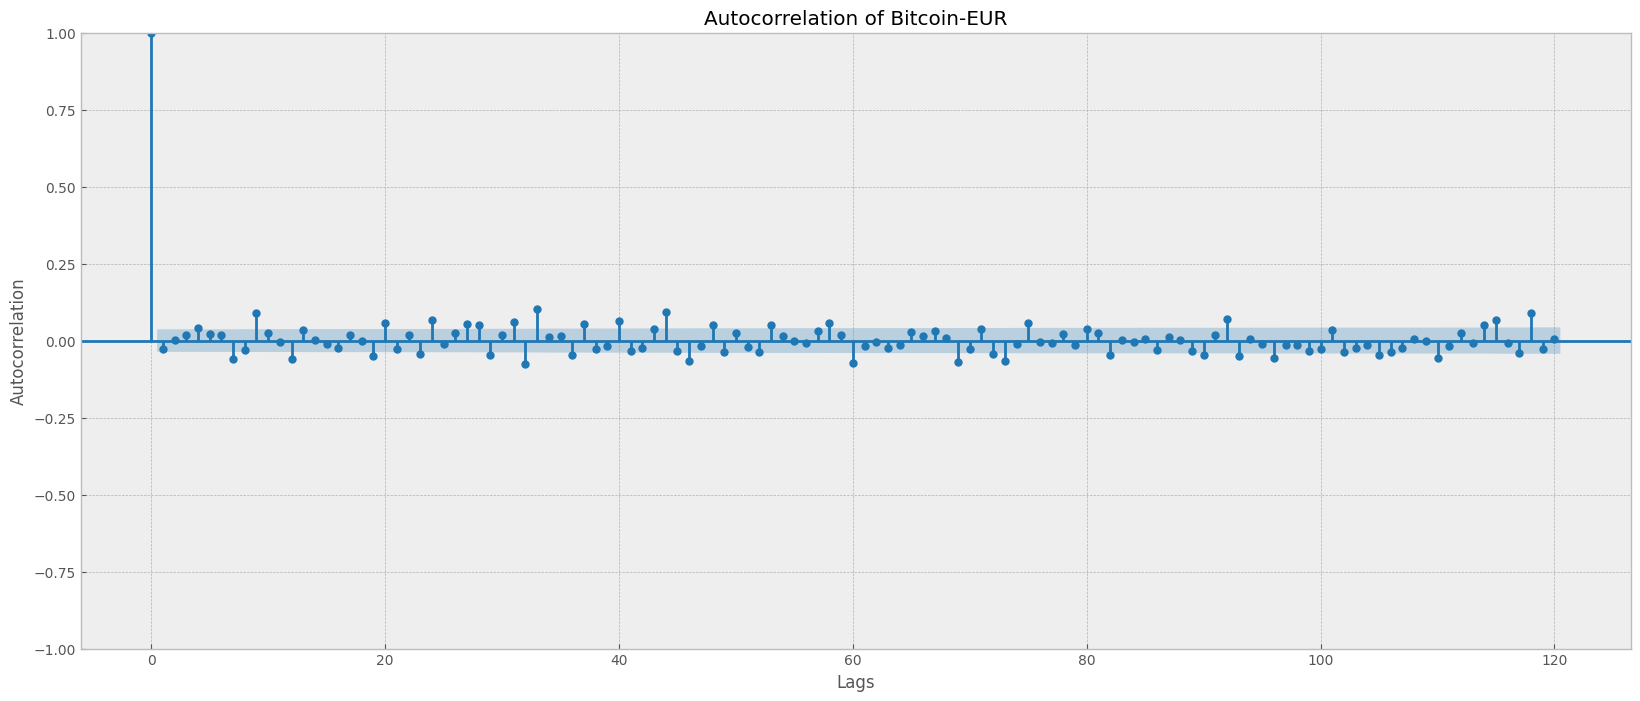

In [59]:
# Autocorrelation (3362 lags = +-10 years)
plot_acf(x = btceur_diff['diff'], lags=120)
plt.title('Autocorrelation of Bitcoin-EUR')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

In [60]:
# Function to calculate autocorrelation
def autocorrelation(series, lag):
    return series.autocorr(lag)

# Assuming btceur_diff DataFrame is already prepared
N = len(btceur_diff['diff'].dropna())
lags = 120
acf_values = [autocorrelation(btceur_diff['diff'].dropna(), lag) for lag in range(lags + 1)]

upper_bounds = [2 / np.sqrt(N/l) for l in range(1, lags+2)]
lower_bounds = [-2 / np.sqrt(N/l) for l in range(1, lags+2)]

# Create a DataFrame for autocorrelation values and confidence intervals
autocorr_df = pd.DataFrame({
    'Lag': list(range(lags + 1)), 
    'Autocorrelation': acf_values,
    'UpperCI': upper_bounds,
    'LowerCI': lower_bounds
})


# Define custom colors
line_color = '#417156'  # Change to your desired color for the line
area_color = '#F6E8D6'  # Change to your desired color for the confidence interval area

# Create the base line chart
base = alt.Chart(autocorr_df).encode(
    x=alt.X('Lag:N', title='Lags')
)

# Autocorrelation line with custom color
autocorr_line = base.mark_line(color=line_color).encode(
    y=alt.Y('Autocorrelation:Q', title='Autocorrelation')
)

# Confidence interval area with custom color
conf_interval_area = base.mark_area(opacity=0.3, color=area_color).encode(
    y='UpperCI:Q',
    y2='LowerCI:Q'
)

# Combine the charts
autocorr_chart = (autocorr_line + conf_interval_area).properties(
    width=1000,
    height=400,
    title='Autocorrelation of First Difference Bitcoin-EUR'
).configure_axis(
    grid=True
)

autocorr_chart


alt.LayerChart(...)

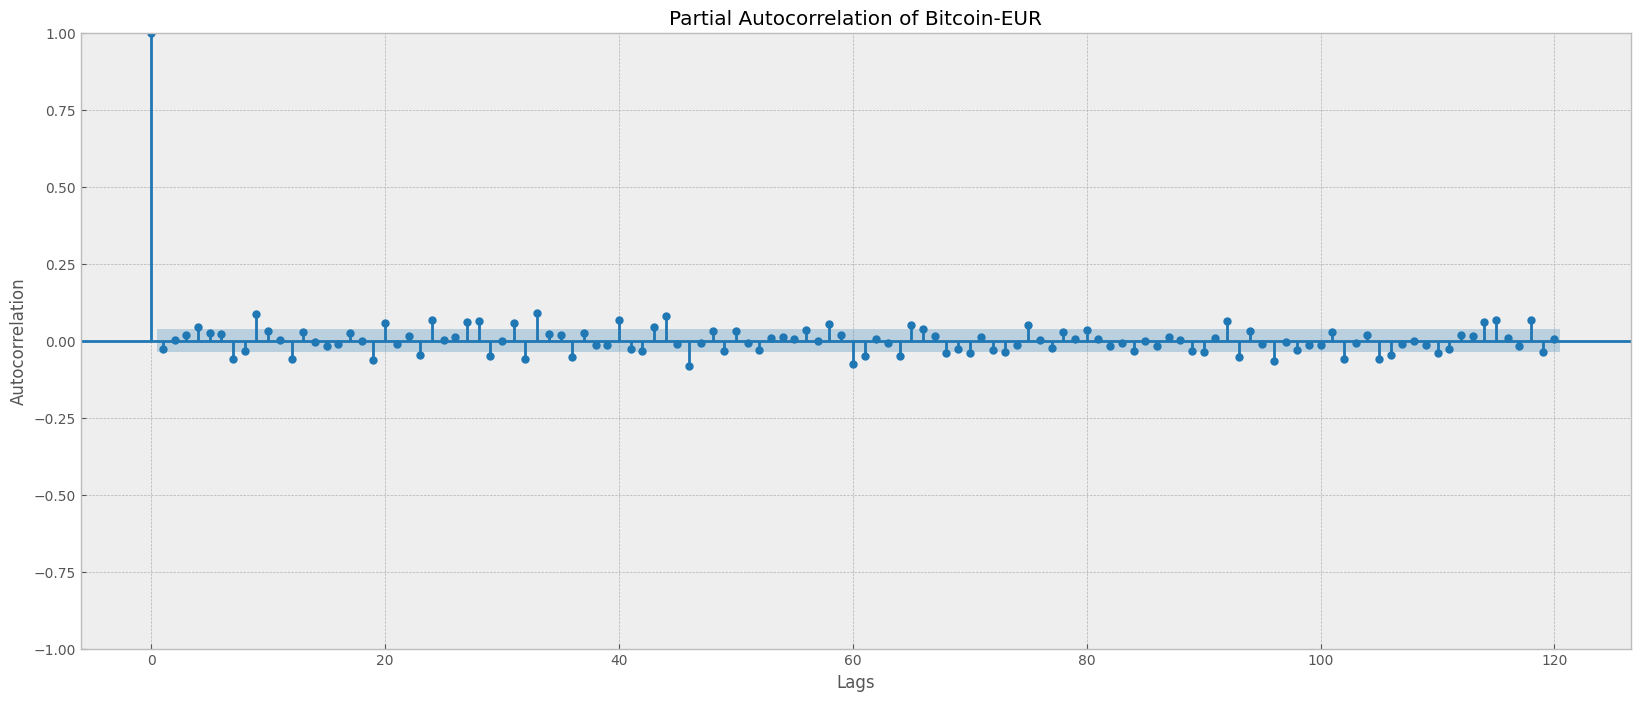

In [61]:
# Autocorrelation (3362 lags = +-10 years)
plot_pacf(x = btceur_diff['diff'], lags=120)
plt.title('Partial Autocorrelation of Bitcoin-EUR')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

In [17]:
from statsmodels.tsa.stattools import pacf

# Provided code for ACF values and confidence intervals
N = len(btceur_diff['diff'].dropna())
lags = 120
pacf_values = pacf(btceur_diff['diff'].dropna(), nlags=lags)

upper_bounds = [2 / np.sqrt(N/l) for l in range(1, lags+2)]
lower_bounds = [-2 / np.sqrt(N/l) for l in range(1, lags+2)]

# Create a DataFrame
autocorr_df = pd.DataFrame({
    'Lag': list(range(lags + 1)), 
    'PartialAutocorrelation':pacf_values,
    'UpperCI': upper_bounds,
    'LowerCI': lower_bounds
})

# Create the base line chart
base = alt.Chart(autocorr_df).encode(
    x=alt.X('Lag:N', title='Lags')
)

# Define custom colors
line_color = '#417156'  # Change to your desired color for the line
area_color = '#F6E8D6'  # Change to your desired color for the confidence interval area


# Autocorrelation line
autocorr_line = base.mark_line(color=line_color).encode(
    y=alt.Y('PartialAutocorrelation:Q', title='Partial Autocorrelation')
)

# Confidence interval area
conf_interval_area = base.mark_area(opacity=0.3, color=area_color).encode(
    y='UpperCI:Q',
    y2='LowerCI:Q'
)

# Combine the charts
autocorr_chart = (autocorr_line + conf_interval_area).properties(
    width=800,
    height=400,
    title='Partial Autocorrelation of Bitcoin-EUR'
).configure_axis(
    grid=True
)

autocorr_chart

alt.LayerChart(...)

### Fit ARIMA model

In [33]:
# Fit ARIMA model
def train_and_plot_arima(df, orders, seasonal_order=(0,0,0,0), exg=None, date=None):
    models = []
    fitted_df = pd.DataFrame()
    fitted_df['date'] = date 
    
    # Store the original data
    fitted_df['Original Dataset'] = df.values
    
    # Loop through each combination and plot the fitted values
    for ar_order, i_order, ma_order in arima_combinations:
        if exg is not None:
            print("ARIMAX")
            model_fit = sm.tsa.SARIMAX(df, exog=exg, 
                                       order=(ar_order, i_order, ma_order), 
                                       seasonal_order=seasonal_order).fit()
        else:    
            model_fit = ARIMA(df, order=(ar_order, i_order, ma_order)).fit()

        fitted_name = f'ARIMAX({ar_order},{i_order},{ma_order})'
        fitted_df[fitted_name] = model_fit.fittedvalues
        
        # Save the model if you need it later
        models.append((model_fit, (ar_order, i_order, ma_order)))

    # Melt the DataFrame for Altair
    fitted_long_df = fitted_df.melt(id_vars=['date'], var_name='Model', value_name='Fitted Values')
    
    # Define the custom color scheme
    color_scheme = alt.Scale(domain=['Original Dataset'] + [f'ARIMAX({ar_order},{i_order},{ma_order})' for ar_order, i_order, ma_order in arima_combinations],
                             range=['black'] + custom_colors[:len(arima_combinations)])
    
    # Create the Altair chart
    chart = alt.Chart(fitted_long_df).mark_line().encode(
        x=alt.X('date:T', axis=alt.Axis(format='%Y-%m')),
        y=alt.Y('Fitted Values:Q', scale=alt.Scale(zero=False)),
        color=alt.Color('Model:N', scale=color_scheme),
        tooltip=['date:T', 'Fitted Values', 'Model']
    ).properties(
        width=800,
        height=400,
        title='Fitted Values of ARIMAX Models'
    )
    
    return chart, models  # Return the chart to display it
def select_model(models):
    aic = models[0][0].aic
    model_fit = models[0][0]
    order = models[0][1]
    for model in models:
        if model[0].aic < aic:
            aic = model[0].aic
            model_fit = model[0]
            order = model[1]
            
    return model_fit, order

In [19]:
# Train ARIMA
arima_combinations = [(ar, i, ma) for ar in [1] for i in [1] for ma in [2]]  # Different combinations of AR and MA orders
chart, models = train_and_plot_arima(train_df['transf'], arima_combinations, date=train_df['date'])
chart

alt.Chart(...)

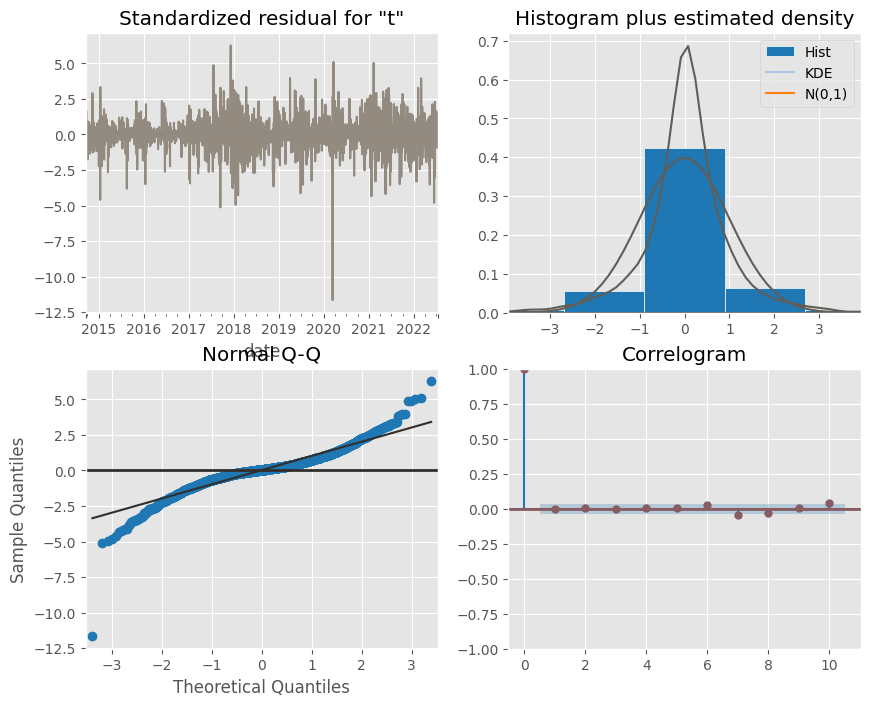

In [20]:
model_fit, order = select_model(models)
line_colors = ["#948B80", "#625D56", "#312E2B", "#875C62"]

# Create the diagnostics plot
fig = model_fit.plot_diagnostics(figsize=(10, 8))

for ax, color in zip(fig.axes, line_colors):
    # Check for line objects in the axes and change their colors
    ax.axhline(y=0, color="#312E2B", linewidth=2) 
    for line in ax.get_lines():
         line.set_color(color) 
    # Additional customizations can be applied to each subplot here

plt.show()


In [104]:
# Test against the the test dataset
# Make predictions on the test set

def forecast_and_plot(model_fit, df, test_df, order=(1,1,2), transformed=False, lambda_optimal=None, exg=None):
    if exg is None:
        predictions = model_fit.forecast(steps=len(test_df['Close']))
    else:
        predictions = model_fit.forecast(steps=len(test_df['Close']), exog=exg)
    if transformed:
        # Assuming inv_boxcox is a defined function to inverse Box-Cox transform
        predictions = inv_boxcox(predictions, lambda_optimal)
    
    # The index of 'predictions' should align with the index of 'test_df'
    predictions.index = test_df.index
    
    # Calculate RMSE
    # rmse = sqrt(mean_squared_error(test_df["Close"], predictions))
    # print('Test RMSE: %.3f' % rmse)
    
    # Combine the training and test data for plotting
    combined_df = pd.concat([df, test_df], keys=['Training', 'Test'], names=['Data', 'Index'])
    combined_df.reset_index(level='Data', inplace=True)
 
    # Add the predictions to the combined DataFrame
    # Convert the Series to a DataFrame
    predictions_df = pd.DataFrame(predictions).reset_index()
    predictions_df.columns = ['Date', 'Close']  # Rename columns appropriately
    predictions_df['Data'] = 'Predicted'
    predictions_df.set_index('Date', inplace=True)
    
    # Concatenate the predictions with the combined DataFrame
    combined_df = pd.concat([combined_df, predictions_df], names=['Data', 'Index'])
    combined_df.reset_index(inplace=True)
    combined_df = combined_df[combined_df['Close'].notna()]
    
    # Define the custom color scheme
    color_scheme = alt.Scale(domain=['Training', 'Test', 'Predicted'],
                             range=["#625D56", "#948B80", "#312E2B"])

    # Create an Altair chart
    chart = alt.Chart(combined_df).mark_line().encode(
        x='index:T',
        y='Close:Q',
        color=alt.Color('Data:N', scale=color_scheme),
        tooltip=['index:T', 'Close:Q', 'Data:N']
    ).properties(
        width=800,
        height=400,
        title=f'Train, Predicted Test, and Actual Test Data, ARIMAX {order}'
    )
    
    return chart, predictions


In [22]:
chart, _ = forecast_and_plot(model_fit, train_df, test_df, transformed=True, lambda_optimal=lambda_optimal)
chart

Test RMSE: 5480.475


alt.Chart(...)

### AUTO Arima and SARIMA

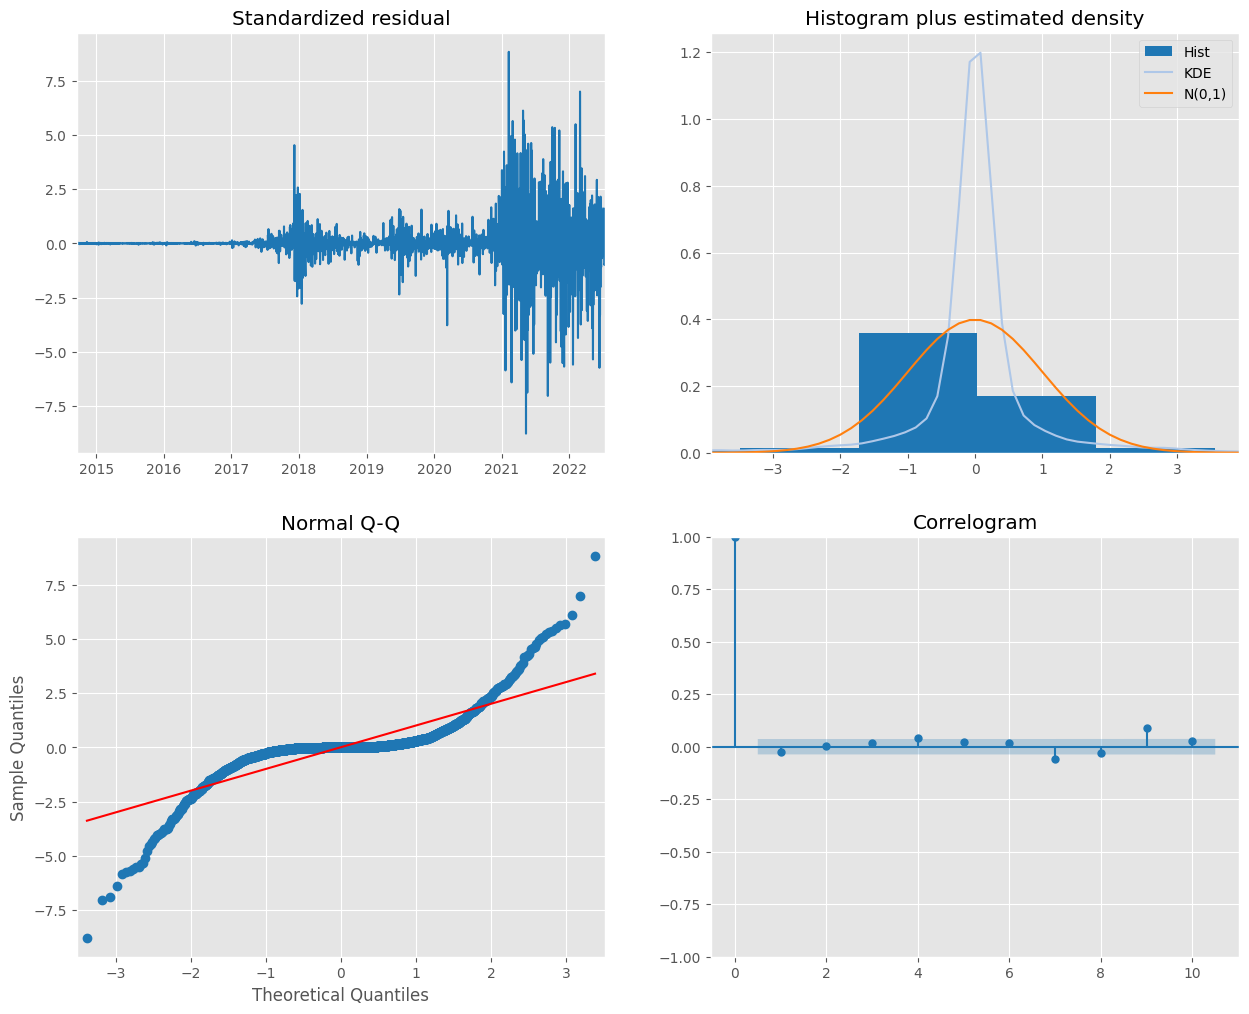

In [23]:
### Use auto arima
ARIMA_model = pm.auto_arima(train_df["Close"], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [31]:
def forecast(ARIMA_model, df, periods=24):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')

    print(index_of_fc)
    
    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df, color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA - Forecast of Airline Passengers")
    plt.show()

forecast(ARIMA_model, train_df["Close"], periods=len(test_df))

NameError: name 'ARIMA_model' is not defined

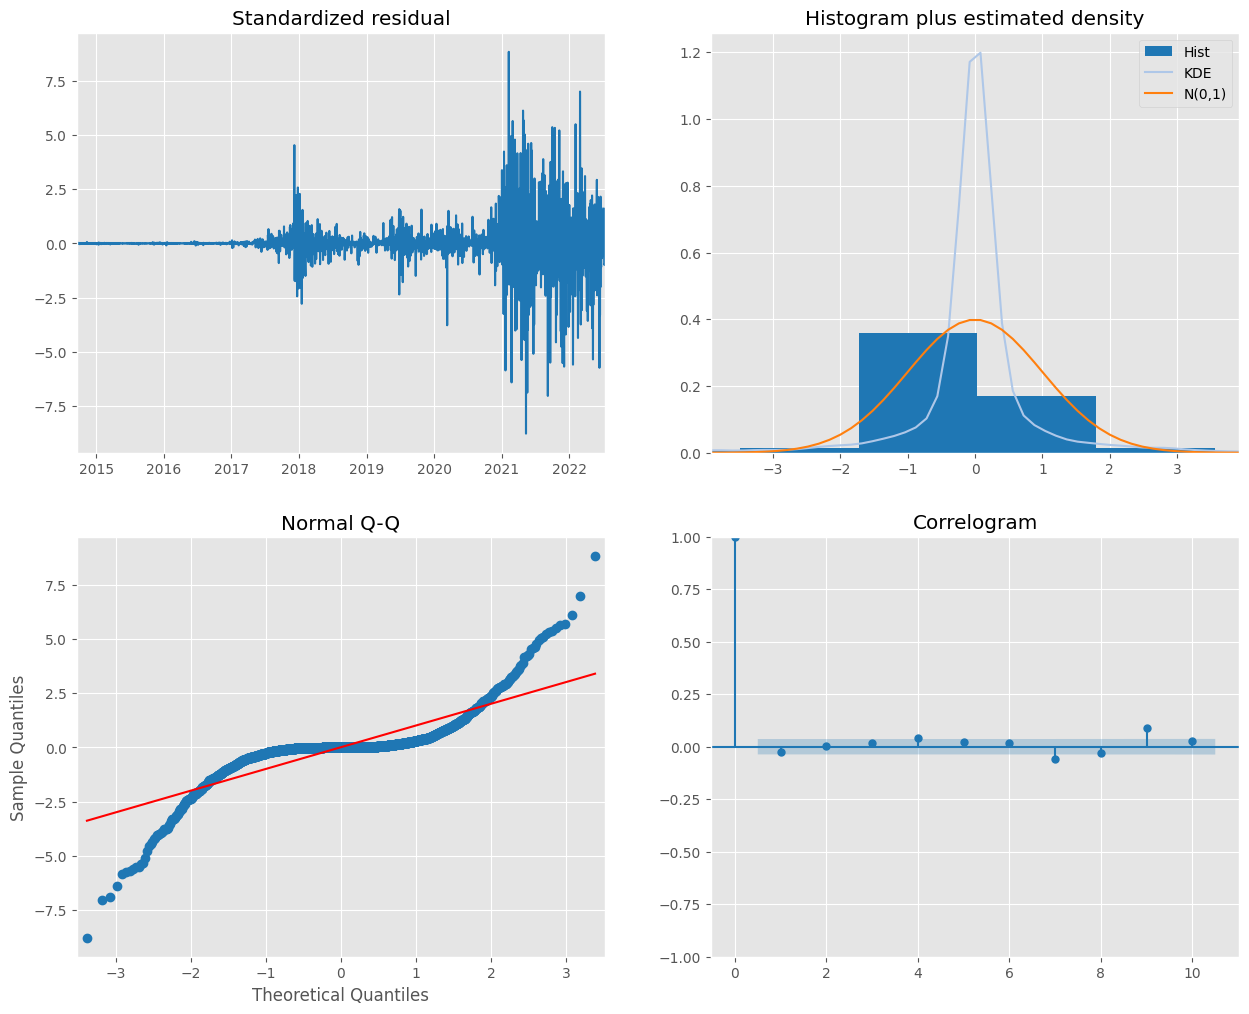

In [25]:
# Train SARIMA
SARIMA_model = pm.auto_arima(train_df["Close"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=1,
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

DatetimeIndex(['2022-07-15', '2022-07-16', '2022-07-17', '2022-07-18',
               '2022-07-19', '2022-07-20', '2022-07-21', '2022-07-22',
               '2022-07-23', '2022-07-24',
               ...
               '2023-11-22', '2023-11-23', '2023-11-24', '2023-11-25',
               '2023-11-26', '2023-11-27', '2023-11-28', '2023-11-29',
               '2023-11-30', '2023-12-01'],
              dtype='datetime64[ns]', length=505, freq='D')


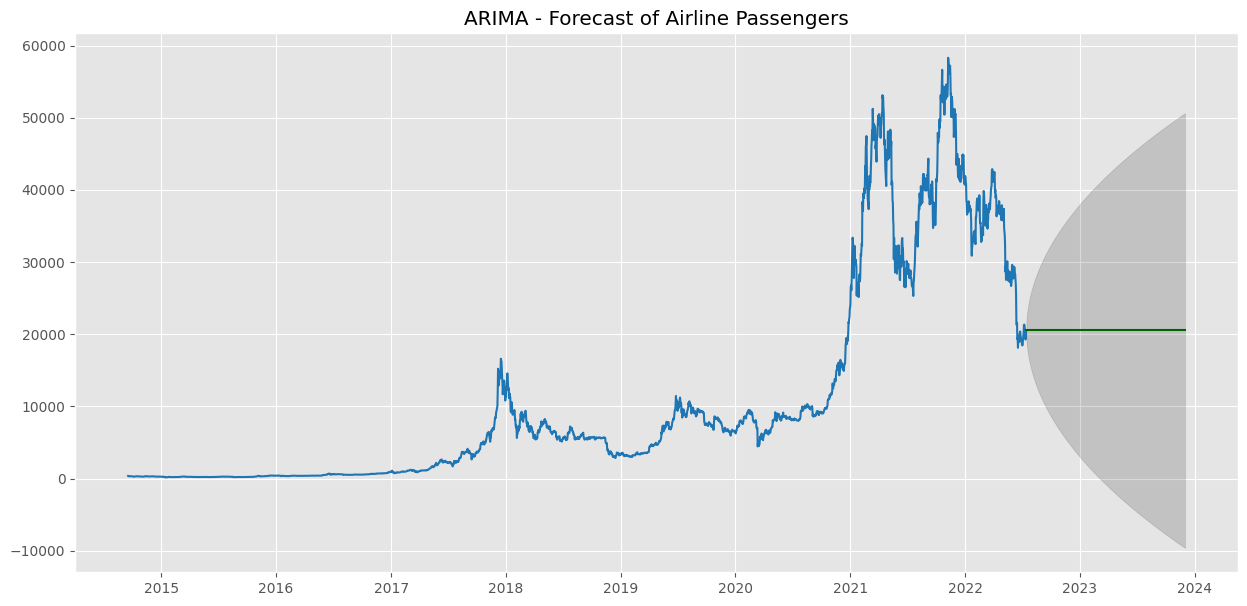

In [26]:
forecast(SARIMA_model, train_df["Close"], periods=len(test_df))

### Fit ARIMAX and SARIMAX

In [94]:
arima_combinations = [(ar, i, ma) for ar in [1] for i in [1] for ma in [2]]  # Different combinations of AR and MA orders
train_df['epoch'] = (train_df['date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
chart, models = train_and_plot_arima(train_df['transf'], arima_combinations, date=train_df['date'], exg=train_df['epoch'])
chart

ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10861D+00    |proj g|=  3.79760D+06


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     21      1     0     0   3.798D+06  -1.109D+00
  F =  -1.1086057120347446     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


alt.Chart(...)

(1, 1, 2)


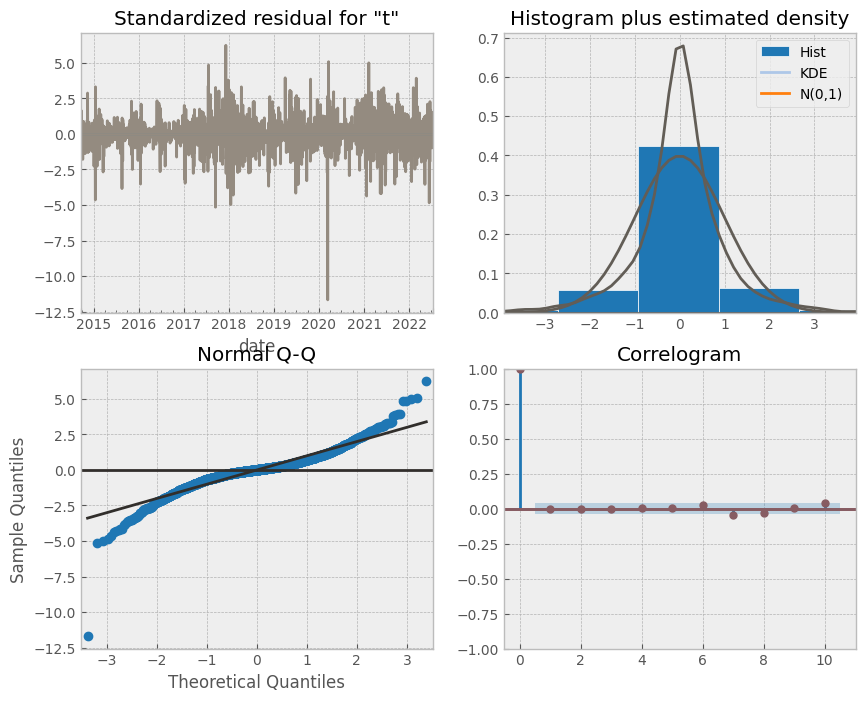

In [95]:
model_fit, order = select_model(models)
print(order)

line_colors = ["#948B80", "#625D56", "#312E2B", "#875C62"]

# Create the diagnostics plot
fig = model_fit.plot_diagnostics(figsize=(10, 8))

for ax, color in zip(fig.axes, line_colors):
    # Check for line objects in the axes and change their colors
    ax.axhline(y=0, color="#312E2B", linewidth=2) 
    for line in ax.get_lines():
         line.set_color(color) 
    # Additional customizations can be applied to each subplot here

plt.show()


In [100]:
import pandas as pd

# Generate date range for 365 days starting from December 2, 2023
date_range = pd.date_range(start="2023-12-02", periods=365, freq="D")

# Create a DataFrame with the "Date" column
df = pd.DataFrame({"date": date_range})
df.index = df['date']

# Initialize the "Close" column with 0
df["Close"] = None
df.head()

test_df = pd.concat([test_df, df])


# Display the first few rows of the DataFrame

In [105]:
test_df['epoch'] = (test_df['date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
chart, predictions = forecast_and_plot(model_fit, combined_df[3200:], test_df, transformed=True, lambda_optimal=lambda_optimal, exg=test_df['epoch'])
chart

alt.Chart(...)

         Date  Close
0  2023-12-02      0
1  2023-12-03      0
2  2023-12-04      0
3  2023-12-05      0
4  2023-12-06      0


In [30]:
test_df['arimax_prediction'] = predictions
arimax_metrics = calculate_forecast_metrics(test_df.dropna(), actual_col='Close', benchmark_cols=['arimax_prediction'])
arimax_metrics.T

MAE           MSE         RMSE       MAPE        R2
arimax_prediction  4752.39902  3.002601e+07  5479.599592  21.988422 -0.444033

### Jump Diffusion Model

5 largest positive single day moves  [0.5807, 0.269, 0.2339, 0.2172, 0.2032]
5 largest negative single day moves [-0.2037, -0.1861, -0.177, -0.168, -0.162]
The probability of jump is 0.059 %


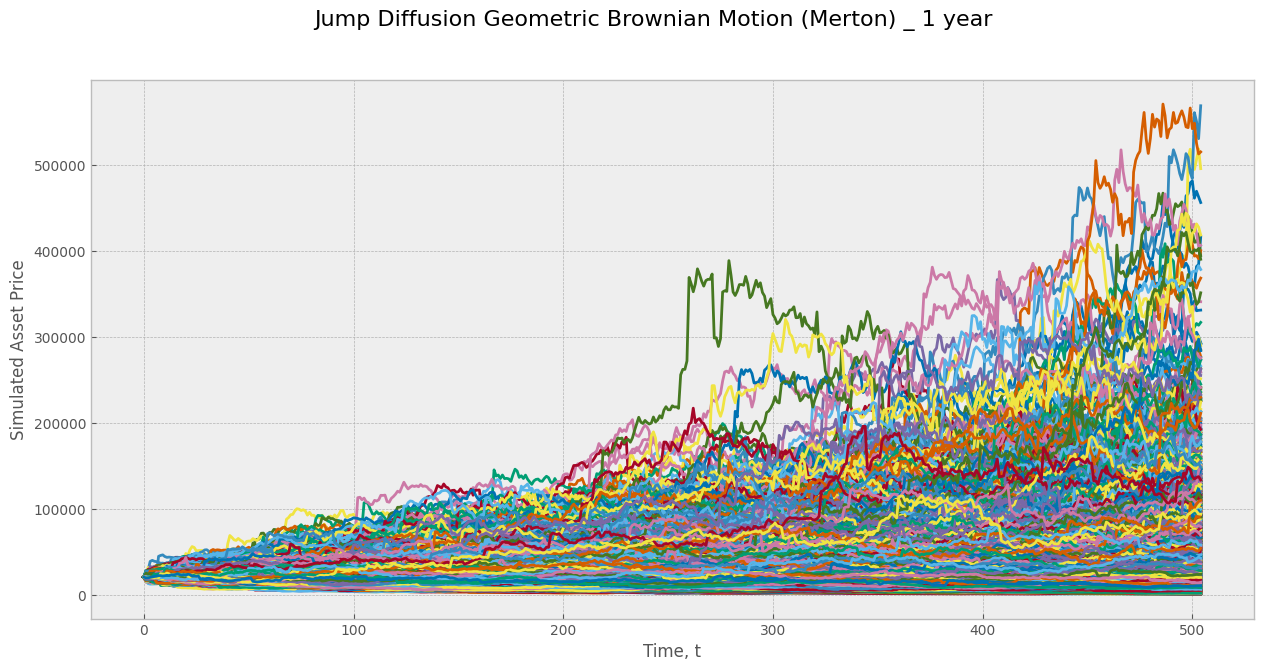

In [31]:
mp, jump_diffusion_examples = merton_jump_diffusion(train_df,'Close',len(test_df))

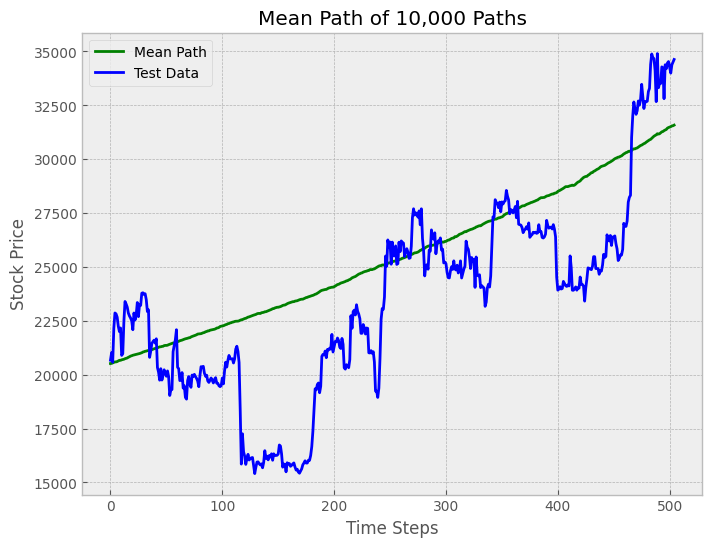

R-squared score: 0.4048296605468569


In [32]:
mean_path = plot_avg_train(jump_diffusion_examples, test_df, 'Close',len(test_df))

In [33]:
test_df['jd_prediction'] = mean_path

In [34]:
#calculate metrics for predictions with the mean_path
diffusion_metrics = calculate_forecast_metrics(test_df, actual_col='Close', benchmark_cols=['jd_prediction'])
diffusion_metrics.T

MAE           MSE         RMSE       MAPE       R2
jd_prediction  2823.273587  1.237547e+07  3517.879295  13.787206  0.40483

In [35]:
#combine all the mtrices
all_metrics_df = pd.concat([diffusion_metrics.T,benchmark_metrics.T, arimax_metrics.T],axis=0)
sorted_df = all_metrics_df.sort_values(by='MSE')
sorted_df.head(20)

MAE           MSE          RMSE  \
jd_prediction                2823.273587  1.237547e+07   3517.879295   
bench_drift_Close            3114.566157  1.599796e+07   3999.745519   
bench_naive_Close            4293.383248  2.925020e+07   5408.345856   
arimax_prediction            4752.399020  3.002601e+07   5479.599592   
bench_seasonal_naive_Close   9437.960630  1.183585e+08  10879.270756   
bench_mean_Close            12620.294932  1.800650e+08  13418.830374   

                                 MAPE        R2  
jd_prediction               13.787206  0.404830  
bench_drift_Close           13.430396  0.230614  
bench_naive_Close           17.347756 -0.406722  
arimax_prediction           21.988422 -0.444033  
bench_seasonal_naive_Close  44.261298 -4.692185  
bench_mean_Close            52.049349 -7.659817

In [41]:
test_df['ARIMAX_pred_transform'] = inv_boxcox(test_df['arimax_prediction'], lambda_optimal)

In [55]:
# Calculate daily returns
test_df['daily_returns'] = np.log(test_df['Close'] / test_df['Close'].shift(1))

# Generate positions based on the predictions
test_df['position'] = np.sign(test_df['arimax_prediction'] - test_df['Close'].shift(1))

# Calculate strategy returns
test_df['strategy_arimax_returns'] = test_df['position'].shift(1) * test_df['daily_returns']

# Calculate cumulative returns
test_df['cum_strategy_arimax_returns'] = test_df['strategy_arimax_returns'].dropna().cumsum().apply(np.exp)
test_df['cum_actual_returns'] = test_df['daily_returns'].dropna().cumsum().apply(np.exp)

# Prepare a long-format DataFrame for Altair
melted_df = test_df.melt(id_vars=['date'], value_vars=['cum_strategy_arimax_returns', 'cum_actual_returns'],
                         var_name='Type', value_name='Returns')

# Define the custom color scheme
color_scheme = alt.Scale(domain=['cum_strategy_arimax_returns', 'cum_actual_returns'],
                         range=["#948B80", "#625D56"])

# Create the Altair chart
chart = alt.Chart(melted_df).mark_line().encode(
    x=alt.X('date:T', axis=alt.Axis(format='%Y-%m')),
    y='Returns:Q',
    color=alt.Color('Type:N', scale=color_scheme),
    tooltip=['date:T', 'Returns:Q', 'Type:N']
).properties(
    width=800,
    height=400,
    title="Gross performance of ARIMAX-based strategy (Test Set)"
)

chart

alt.Chart(...)

In [48]:
# Calculate daily returns
test_df['daily_returns'] = np.log(test_df['Close'] / test_df['Close'].shift(1))

# Generate positions based on the predictions
test_df['position'] = np.sign(test_df['bench_drift_Close'] - test_df['Close'].shift(1))

# Calculate strategy returns
test_df['bench_drift_Close_returns'] = test_df['position'].shift(1) * test_df['daily_returns']

# Calculate cumulative returns
test_df['cum_strategy_bd_returns'] = test_df['bench_drift_Close_returns'].dropna().cumsum().apply(np.exp)
test_df['cum_actual_returns'] = test_df['daily_returns'].dropna().cumsum().apply(np.exp)

# Prepare a long-format DataFrame for Altair
melted_df = test_df.melt(id_vars=['date'], value_vars=['cum_strategy_bd_returns', 'cum_actual_returns'],
                         var_name='Type', value_name='Returns')

# Define the custom color scheme
color_scheme = alt.Scale(domain=['cum_strategy_bd_returns', 'cum_actual_returns'],
                         range=["#948B80", "#625D56"])

# Create the Altair chart
chart = alt.Chart(melted_df).mark_line().encode(
    x=alt.X('date:T', axis=alt.Axis(format='%Y-%m')),
    y='Returns:Q',
    color=alt.Color('Type:N', scale=color_scheme),
    tooltip=['date:T', 'Returns:Q', 'Type:N']
).properties(
    width=800,
    height=400,
    title="Gross performance of Bench Drift-based strategy (Test Set)"
)

chart

alt.Chart(...)

In [46]:
# Calculate daily returns
test_df['daily_returns'] = np.log(test_df['Close'] / test_df['Close'].shift(1))

# Generate positions based on the predictions
test_df['position_bn'] = np.sign(test_df['bench_naive_Close'] - test_df['Close'].shift(1))

# Calculate strategy returns
test_df['strategy_bn_returns'] = test_df['position_bn'].shift(1) * test_df['daily_returns']

# Calculate cumulative returns
test_df['cum_strategy_bn_returns'] = test_df['strategy_bn_returns'].dropna().cumsum().apply(np.exp)
test_df['cum_actual_returns'] = test_df['daily_returns'].dropna().cumsum().apply(np.exp)

# Prepare a long-format DataFrame for Altair
melted_df = test_df.melt(id_vars=['date'], value_vars=['cum_strategy_bn_returns', 'cum_actual_returns'],
                         var_name='Type', value_name='Returns')

# Define the custom color scheme
color_scheme = alt.Scale(domain=['cum_strategy_bn_returns', 'cum_actual_returns'],
                         range=["#948B80", "#625D56"])

# Create the Altair chart
chart = alt.Chart(melted_df).mark_line().encode(
    x=alt.X('date:T', axis=alt.Axis(format='%Y-%m')),
    y='Returns:Q',
    color=alt.Color('Type:N', scale=color_scheme),
    tooltip=['date:T', 'Returns:Q', 'Type:N']
).properties(
    width=800,
    height=400,
    title="Gross performance of Bench Naive-based strategy (Test Set)"
)

chart

alt.Chart(...)

In [47]:
# Calculate daily returns
test_df['daily_returns'] = np.log(test_df['Close'] / test_df['Close'].shift(1))

# Generate positions based on the predictions
test_df['position_jd'] = np.sign(test_df['jd_prediction'] - test_df['Close'].shift(1))

# Calculate strategy returns
test_df['strategy_jd_returns'] = test_df['position_jd'].shift(1) * test_df['daily_returns']

# Calculate cumulative returns
test_df['cum_strategy_jd_returns'] = test_df['strategy_jd_returns'].dropna().cumsum().apply(np.exp)
test_df['cum_actual_returns'] = test_df['daily_returns'].dropna().cumsum().apply(np.exp)

# Prepare a long-format DataFrame for Altair
melted_df = test_df.melt(id_vars=['date'], value_vars=['cum_strategy_jd_returns', 'cum_actual_returns'],
                         var_name='Type', value_name='Returns')

# Define the custom color scheme
color_scheme = alt.Scale(domain=['cum_strategy_jd_returns', 'cum_actual_returns'],
                         range=["#948B80", "#625D56"])

# Create the Altair chart
chart = alt.Chart(melted_df).mark_line().encode(
    x=alt.X('date:T', axis=alt.Axis(format='%Y-%m')),
    y='Returns:Q',
    color=alt.Color('Type:N', scale=color_scheme),
    tooltip=['date:T', 'Returns:Q', 'Type:N']
).properties(
    width=800,
    height=400,
    title="Gross performance of Jump diffusion-based strategy (Test Set)"
)

chart

alt.Chart(...)

5 largest positive single day moves  [0.5807, 0.269, 0.2339, 0.2172, 0.2032]
5 largest negative single day moves [-0.2037, -0.1861, -0.177, -0.168, -0.162]
The probability of jump is 0.059 %


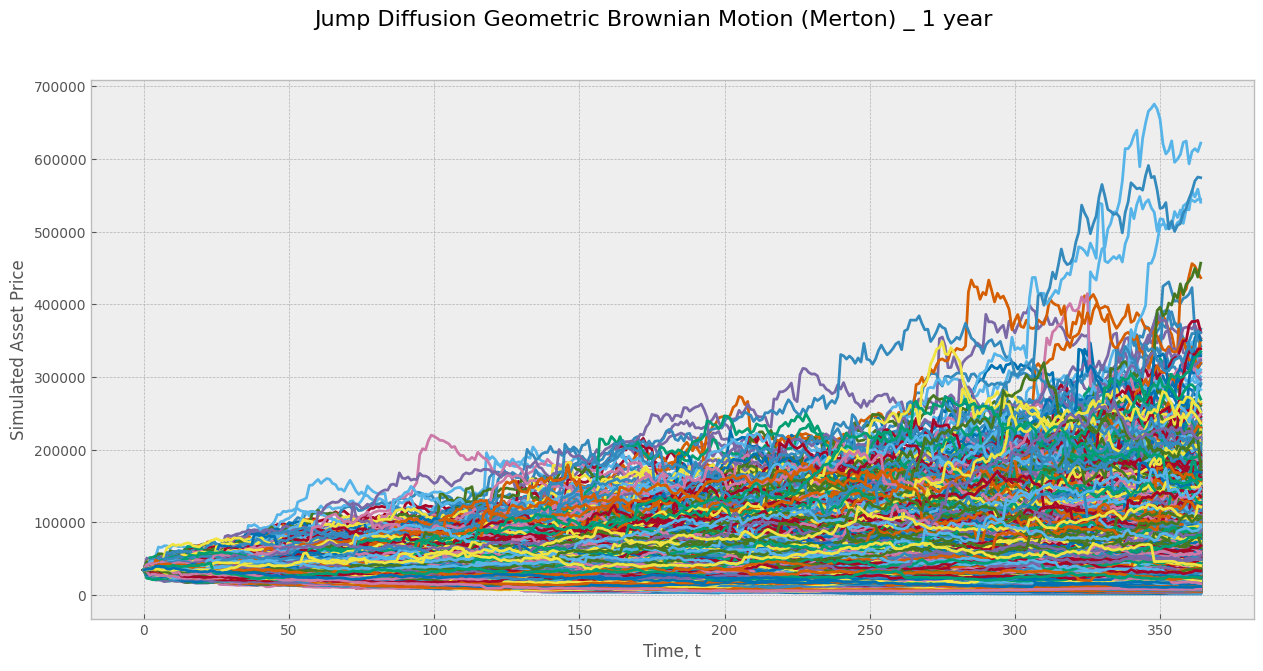

In [22]:
mp, jump_diffusion_examples = merton_jump_diffusion(combined_df,'Close',365)

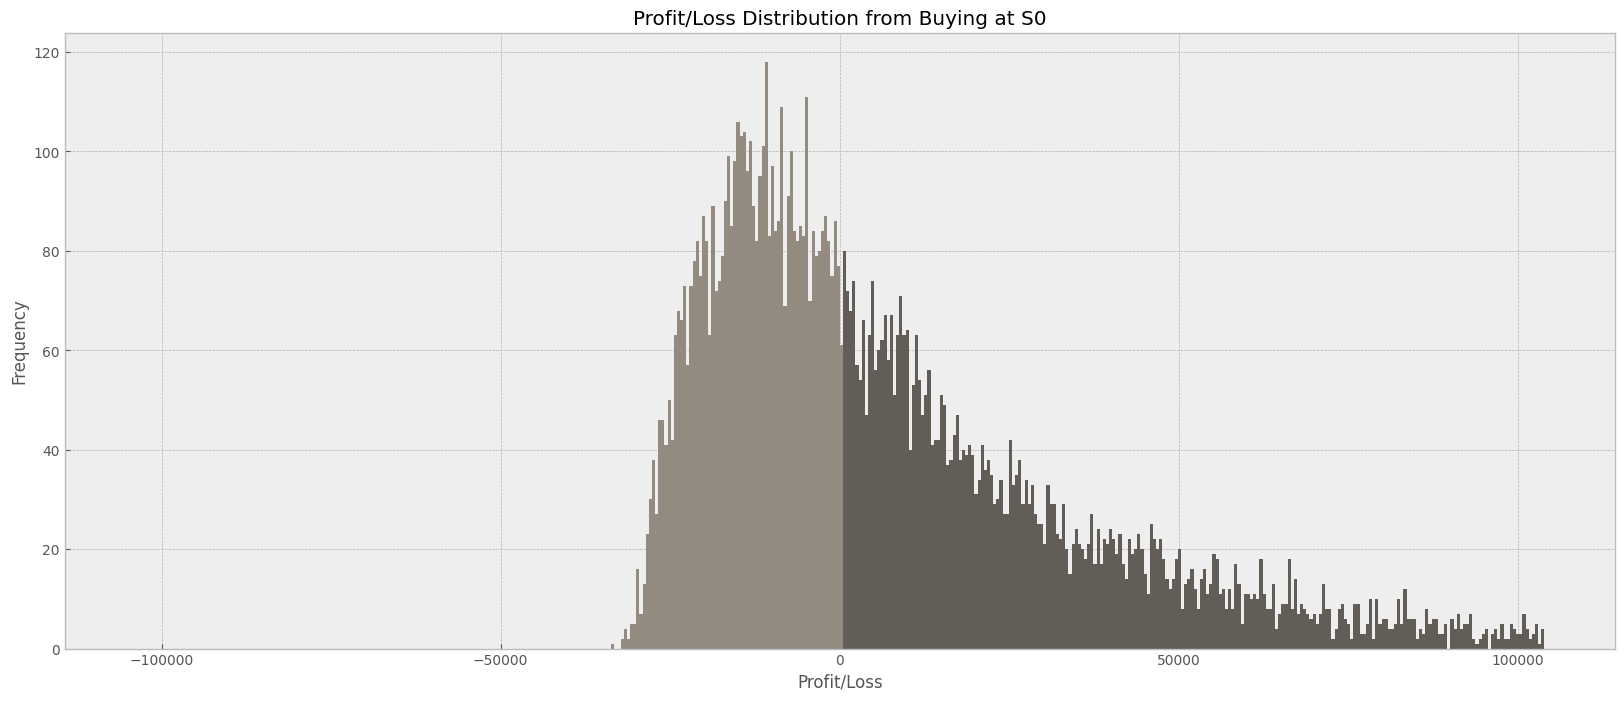

Mean: 11564.444304634002
Minimum: -33261.54229586186
Maximum: 587180.8374258443
25th percentile (Q1): -12740.064543643603
Median (50th percentile): 596.1820503290801
75th percentile (Q3): 22939.608110096204


In [23]:
def get_profit_loss_impl(S0, jump_diffusion_examples):
    # Calculate profit/loss for each path based on buying at S0 and selling at final price
    final_prices = get_finalPrices(jump_diffusion_examples)
    profit_loss_from_S0 = np.array([final_price - S0 for final_price in final_prices])

    # Plotting the profit/loss distribution
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(profit_loss_from_S0, bins=450, range=[-S0*3, S0*3], color='gray')
    for i, patch in enumerate(patches):
        if bins[i] <= 0:
            patch.set_fc('#948B80')  # Set color for losses
        else:
            patch.set_fc('#625D56')  # Set color for profits
    plt.title("Profit/Loss Distribution from Buying at S0")
    plt.xlabel("Profit/Loss")
    plt.ylabel("Frequency")
    plt.show()

    # Calculate statistics
    mean = np.mean(profit_loss_from_S0)
    minimum = np.min(profit_loss_from_S0)
    maximum = np.max(profit_loss_from_S0)
    q1, median, q3 = np.percentile(profit_loss_from_S0, [25, 50, 75])

    # Print statistics
    print("Mean:", mean)
    print("Minimum:", minimum)
    print("Maximum:", maximum)
    print("25th percentile (Q1):", q1)
    print("Median (50th percentile):", median)
    print("75th percentile (Q3):", q3)
    
S0 = combined_df.iloc[-1]['Close']
get_profit_loss_impl(S0, jump_diffusion_examples)

In [113]:
train_df_lstm = train_df.copy()
test_df_lstm = test_df.copy()

In [147]:
from fastai.tabular.all import *
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

window_size = 15

def preprocess(df, window_size=window_size, valid_pct=0.2, train=True):
    # Scale the 'Close' column
    scaler = MinMaxScaler()
    close_scaled = scaler.fit_transform(df[['Close']])
    
    # Ensure that you have enough data points to create sequences
    if len(close_scaled) < window_size + 1:
        raise ValueError("Not enough data points to create sequences.")

    
    # Prepare sequences
    sequences = L([torch.tensor(close_scaled[i:i+window_size], dtype=torch.float32) 
                   for i in range(len(close_scaled)-window_size)])
    targets = L([torch.tensor(close_scaled[i+window_size], dtype=torch.float32) 
                 for i in range(len(close_scaled)-window_size)])

    # Check if sequences are created
    if not sequences or not targets:
        raise ValueError("No sequences or targets were created. Check your data and window size.")
    
    if train:
        # Split data into training and validation sets
        train_size = int(len(sequences) * (1 - valid_pct))
        train_sequences, train_targets = sequences[:train_size], targets[:train_size]
        valid_sequences, valid_targets = sequences[train_size:], targets[train_size:]
        train_dates = df['date'][:len(train_targets)].reset_index(drop=True)
        valid_dates = df['date'][:len(valid_targets)].reset_index(drop=True)
        # Create DataLoader from sequences
        train_ds = list(zip(train_sequences, train_targets))
        valid_ds = list(zip(valid_sequences, valid_targets))
        dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=32, shuffle=False,)
        return dls, [train_dates, valid_dates], scaler
    else:
        # Assuming sequences and targets are your full dataset
        train_ds = list(zip(sequences, targets))
        # Create a DataLoader for training
        dates = df['date'][:len(targets)].reset_index(drop=True)
        dls = DataLoader(train_ds, batch_size=32, shuffle=False)
        return dls, [dates], scaler
    
train_loader, train_dates, train_scaler = preprocess(train_df_lstm)
test_loader, test_dates, test_scaler = preprocess(test_df_lstm, train=False)

print(train_dates[0][0], train_dates[0][-1:])
print(train_dates[1][0], train_dates[1][-1:])
print(test_dates[0][0], test_dates[0][-1:])

2014-09-17 00:00:00 2261   2020-11-25
Name: date, dtype: datetime64[ns]
2014-09-17 00:00:00 565   2016-04-04
Name: date, dtype: datetime64[ns]
2022-07-15 00:00:00 474   2023-11-01
Name: date, dtype: datetime64[ns]


In [149]:
class MyLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = torch.nn.LSTM(input_size, hidden_layer_size)
        self.linear = torch.nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        # Detach the hidden cell state to prevent backpropagating through the entire training history
        self.hidden_cell = (self.hidden_cell[0].detach(), self.hidden_cell[1].detach())

        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions.squeeze()

model = MyLSTM(input_size=window_size)  # Ensure input_size matches the sequence length
learn = Learner(train_loader, model, loss_func=torch.nn.MSELoss(), metrics=[mse])
learn.fit_one_cycle(10)

In [150]:
# Switch to evaluation mode
learn.model.eval()

# Get predictions for training set
test_preds, test_targets = learn.get_preds(dl=test_loader)

# Convert to NumPy arrays
test_preds = test_preds.numpy().flatten()
test_targets = test_targets.numpy().flatten()

rescaled_targets = pd.DataFrame(test_scaler.inverse_transform(pd.DataFrame(test_targets)))
rescaled_preds = pd.DataFrame(test_scaler.inverse_transform(pd.DataFrame(test_preds)))

test_dates[0] = pd.to_datetime(test_dates[0])

# Creating a DataFrame for the plot
data = pd.DataFrame({
    'Date': test_dates[0],
    'Actual_Values': rescaled_targets[rescaled_targets.columns[0]],
    'Predicted_Values': rescaled_preds[rescaled_preds.columns[0]],
    'Residuals': rescaled_targets[rescaled_targets.columns[0]] - rescaled_preds[rescaled_preds.columns[0]]
})

data['Upper'] = 2 / np.sqrt(len(data))
data['Lower'] = -2 / np.sqrt(len(data))

# Melting the DataFrame for Altair
data_long = data.melt('Date', var_name='Category', value_name='Value')

# Define the custom color scheme
domain = ['Actual_Values', 'Predicted_Values']
range_ = ["#625D56", "#875C62"]  # Select appropriate colors from your custom palette

# Create the line chart
line_chart = alt.Chart(data_long).mark_line().encode(
    x=alt.X('Date:T', axis=alt.Axis(format=("%Y-%m"))),
    y=alt.Y('Value:Q', scale=alt.Scale(domain=[data['Actual_Values'].min() - 0.01, data['Actual_Values'].max() + 0.01 ])),
    color=alt.Color('Category:N', scale=alt.Scale(domain=domain, range=range_)),
    tooltip=['Date:T', 'Value:Q', 'Category:N']
).properties(
    width=700,
    height=450,
    
)


# Residuals plot
residuals_chart = alt.Chart(data).mark_bar(opacity=0.7, color="#875C62", size=1).encode(
    x=alt.X('Date:T', axis=alt.Axis(format='%Y-%m', labels=False), title=None),
    y='Residuals:Q',
    tooltip=['Date:T', 'Residuals:Q']
).properties(
    width=700,
    height=50,
    title='Test Set LSTM: Actual vs Predicted Values'
)

ci = residuals_chart.mark_area(opacity=0.3, color="#F6E8D6", size=1).encode(
    x=alt.X('Date:T', axis=alt.Axis(format='%Y-%m', labels=False), title=None),
    y='Upper:Q',
    y2='Lower:Q'
).properties(
    width=700,
    height=50
)

# Combine the charts
combined_chart = alt.vconcat(residuals_chart+ci, line_chart, ).resolve_scale(
    x='shared'  # Ensure the x-axis is aligned
).properties()

combined_chart.to_json("graphs/eurusd/lstmtest.json")
combined_chart

alt.VConcatChart(...)

In [152]:
# Starting with the last window of actual data
current_window = test_preds[-window_size:].tolist()

# List to store future predictions
future_predictions = []

# Predicting the next 'n_future_steps' values
n_future_steps = 365
for _ in range(n_future_steps):
    # Use current window to predict the next value
    with torch.no_grad():
        current_window_tensor = torch.tensor(current_window[-window_size:]).view(1, -1, 1).float()
        next_pred = model(current_window_tensor).item()
    
    # Append prediction to future predictions
    future_predictions.append(next_pred)

    # Update the current window
    current_window.append(next_pred)

rescaled_predictions = pd.DataFrame(test_scaler.inverse_transform(pd.DataFrame(future_predictions)))
    
# Plotting
future_dates = pd.date_range(start=test_dates[0].iloc[-1], periods=n_future_steps, freq='D')


# Creating a DataFrame for the plot
data = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Values': rescaled_predictions[rescaled_preds.columns[0]]
})

# Melting the DataFrame for Altair
data_long = data.melt('Date', var_name='Category', value_name='Value')

# Define the custom color scheme
domain = ['Predicted_Values']
range_ = ["#625D56", "#875C62"]  # Select appropriate colors from your custom palette

# Create the line chart
line_chart = alt.Chart(data_long).mark_line().encode(
    x=alt.X('Date:T', axis=alt.Axis(format=("%Y-%m"))),
    y=alt.Y('Value:Q', scale=alt.Scale(domain=[data['Predicted_Values'].min() - 0.01, data['Predicted_Values'].max() + 0.01 ])),
    color=alt.Color('Category:N', scale=alt.Scale(domain=domain, range=range_)),
    tooltip=['Date:T', 'Value:Q', 'Category:N']
).properties(
    width=700,
    height=200,
    title="LSTM Model Prediction for 2024"
)

line_chart

alt.Chart(...)